In [77]:
import pandas as pd
import numpy as np
import json
from scipy.sparse import csr_matrix, identity
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score
from sklearn.metrics import accuracy_score, f1_score
import itertools
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

## Load data

In [78]:
cards = pd.read_csv('../data/raw/B1/cards_data.csv')
transactions_1 = pd.read_csv( '../data/raw/B1/transactions_part1.csv')
transactions_2 = pd.read_csv('../data/raw/B1/transactions_part2.csv')
users = pd.read_csv( '../data/raw/B1/users_data.csv')
transactions = pd.concat([transactions_1, transactions_2], ignore_index=True)

In [79]:
cards.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [80]:
transactions.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,22038356,2018-11-01 00:00:00,316,2038,$91.31,Chip Transaction,75781,Houston,TX,77051.0,5411,Insufficient Balance
1,22038357,2018-11-01 00:02:00,637,2981,$8.77,Chip Transaction,30928,Saint Cloud,MN,56301.0,5541,NaN
2,22038358,2018-11-01 00:04:00,316,5857,$78.08,Chip Transaction,75781,Houston,TX,77051.0,5411,NaN
3,22038359,2018-11-01 00:06:00,554,2308,$4.02,Chip Transaction,60939,La Porte,TX,77571.0,5211,NaN
4,22038360,2018-11-01 00:06:00,1129,102,$80.00,Chip Transaction,27092,Vista,CA,92084.0,4829,NaN


In [81]:
users.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [82]:
cards['credit_limit']= cards['credit_limit'].replace({'\$': ''}, regex=True).astype(float)
users.loc[:,"per_capita_income":"total_debt"]=users.loc[:,"per_capita_income":"total_debt"].apply(lambda x: x.replace({'\$': ''}, regex=True).astype(float))

# EDA on cards data

In [83]:
cards.dtypes

id                         int64
client_id                  int64
card_brand                object
card_type                 object
card_number                int64
expires                   object
cvv                        int64
has_chip                  object
num_cards_issued           int64
credit_limit             float64
acct_open_date            object
year_pin_last_changed      int64
card_on_dark_web          object
dtype: object

In [84]:
cards.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,24295.0,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,21968.0,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,46414.0,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,12400.0,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,28.0,09/2008,2009,No


/var/folders/tv/3hrqdjcx0qgbm22_5rmgrbd40000gn/T/ipykernel_56716/2442942232.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cards, x=col, ax=ax, palette="viridis")
/var/folders/tv/3hrqdjcx0qgbm22_5rmgrbd40000gn/T/ipykernel_56716/2442942232.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/tv/3hrqdjcx0qgbm22_5rmgrbd40000gn/T/ipykernel_56716/2442942232.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cards, x=col, ax=ax, palette="viridis")
/var/folders/tv/3hrqdjcx0qgbm22_5rmgrbd40000gn/T/ipykernel_56716/24

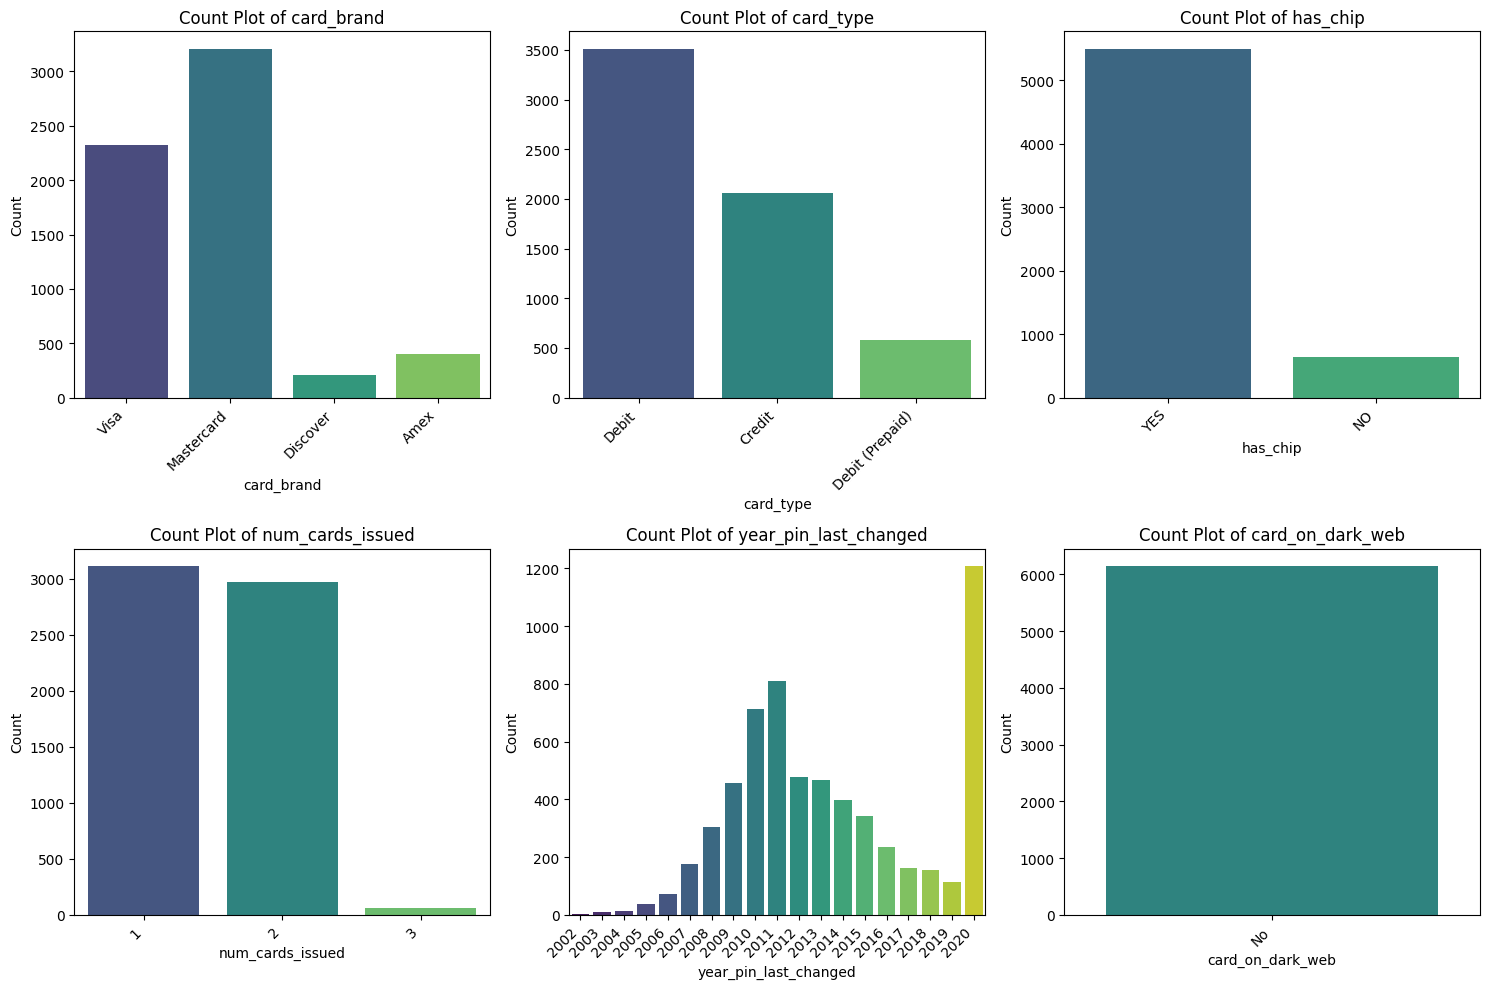

In [85]:
# List of columns for which to generate count plots
cols_to_plot = [
    "card_brand", 
    "card_type", 
    "has_chip", 
    "num_cards_issued", 
    "year_pin_last_changed", 
    "card_on_dark_web"
]

# Create subplots: 2 rows x 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for ax, col in zip(axes, cols_to_plot):
    sns.countplot(data=cards, x=col, ax=ax, palette="viridis")
    ax.set_title(f"Count Plot of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


plt.tight_layout()
plt.show()

In [86]:
# 1) Parse columns into datetime (if they are in MM/YYYY format).
cards["acct_open_year"] = pd.to_datetime(cards["acct_open_date"], format="%m/%Y", errors="coerce").dt.year
cards["expires_year"] = pd.to_datetime(cards["expires"], format="%m/%Y", errors="coerce").dt.year

# 2) Group credit_limit by bins of 5000
max_limit = cards["credit_limit"].max() if cards["credit_limit"].notnull().any() else 0
bins = range(0, int(max_limit + 5000), 5000)
cards["credit_limit_bin"] = pd.cut(cards["credit_limit"], bins=bins)

# Now we have 3 new columns:
#  - acct_open_year
#  - expires_year
#  - credit_limit_bin


/var/folders/tv/3hrqdjcx0qgbm22_5rmgrbd40000gn/T/ipykernel_56716/1152776004.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cards, x="acct_open_year", ax=axes[0], palette="viridis")
/var/folders/tv/3hrqdjcx0qgbm22_5rmgrbd40000gn/T/ipykernel_56716/1152776004.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
/var/folders/tv/3hrqdjcx0qgbm22_5rmgrbd40000gn/T/ipykernel_56716/1152776004.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cards, x="expires_year", ax=axes[1], palette="viridis")
/var/folders/tv/3hrqdjcx0

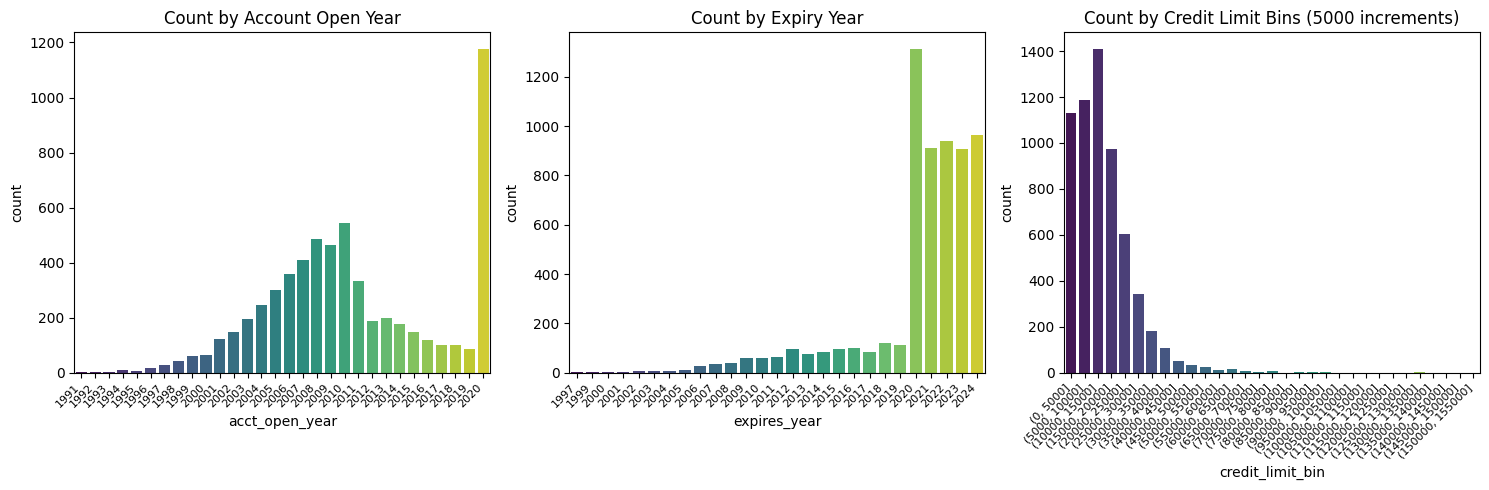

In [87]:
# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# (A) Count by Account Open Year
sns.countplot(data=cards, x="acct_open_year", ax=axes[0], palette="viridis")
axes[0].set_title("Count by Account Open Year")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
axes[0].tick_params(axis='x', labelsize=8)

# (B) Count by Expires Year
sns.countplot(data=cards, x="expires_year", ax=axes[1], palette="viridis")
axes[1].set_title("Count by Expiry Year")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
axes[1].tick_params(axis='x', labelsize=8)

# (C) Count by Credit Limit Bins (5000 increments)
sns.countplot(data=cards, x="credit_limit_bin", ax=axes[2], palette="viridis")
axes[2].set_title("Count by Credit Limit Bins (5000 increments)")
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")
axes[2].tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()


### 1. Card Brand, Card Type, and Has Chip
- **Card Brand (Visa, Mastercard, etc.)**  
  - Most customers are using Visa and Mastercard, the institution might **co-brand** or offer **special promotions** with that network, opening opportunities for **brand-specific reward programs**.

- **Card Type (Debit, Credit, Prepaid)**  
  - A higher proportion of **Debit** cards might indicate a **risk-averse** user base or those preferring to avoid credit lines.  
  - A sizable **Credit** card segment suggests potential for **credit-line expansions**, **balance transfer offers**, or **premium card upgrades**.

- **Has Chip (YES/NO)**  
  - Most cards are chip-enabled, which is standard for **fraud prevention**.  
  - A minority with **NO** chip can be targeted for **card upgrades** emphasizing security benefits.

**Business Implication**: Knowing card types and brand preferences helps you **personalize offers**. For instance, a customer with multiple debit cards might be ready for a **rewards credit card**; a large base of Visa credit card holders could be offered **exclusive Visa promotions**.

---

### 2. Number of Cards Issued
- **Distribution** shows most customers hold 1–2 cards, with a smaller segment holding 3 or more.
- Users with fewer cards (e.g., 1) may be good candidates for **cross-selling** an additional credit or specialty card (travel, cashback, etc.).
- Customers already at 2+ might appreciate **product upgrades** or **consolidation** offers, depending on usage patterns.

**Business Implication**: This feature indicates how **financially engaged** a customer is.  
- **Low engagement** (1 card) → cross-sell a new card or **limit increase**.  
- **High engagement** (multiple cards) → **premium product** or **advanced services** like **investment accounts**.


---

### 3. Card on Dark Web
- All customers are not on dark web, it indicates a **low incidence** of compromised cards.  

**Business Implication**:  
- For the rest: Market it as a **value-add** (peace of mind, free identity monitoring).

---

### 5. Account Open Year
- Shows the **tenure** of the account. Many accounts are opened in year 2020 and after, which might indicate a successful acquisition campaign.
- **Long-standing customers** are often **loyal** and may respond well to **relationship-based** offers (e.g., mortgage, investment).
- **Newer accounts** might need **welcome promotions** or **onboarding** into higher-tier products.

**Business Implication**:  
- Segment customers by **vintage**.  
- **Older accounts** → upsell more complex financial products (e.g., **loans**, **investment portfolios**).  
- **Newer accounts** → basic credit or deposit products to **build loyalty**.


---

### 6. Credit Limit Bins
- Shows how credit limits are distributed across customers, with a **peak** in the $10000 to $15000 and fewer high-limit customers.
- **Lower-limit** customers may be good candidates for **limit increases** if they demonstrate responsible usage.
- **Higher-limit** customers may qualify for **premium or exclusive** offers (concierge services, travel rewards).

**Business Implication**:  
- Align credit-limit segmentation with **risk appetite** and **customer spending**.  
- **Low-limit** segment → cross-sell an **upgrade** if their credit score and usage are strong.  
- **High-limit** segment → advanced **wealth management** or **VIP** offerings.

## Drop unnecessary columns

In [88]:
cards.drop(columns=cards.loc[:,'acct_open_date':'card_on_dark_web'], inplace=True)
cards.drop(columns=cards.loc[:,'card_number':'num_cards_issued'], inplace=True)
cards.head()

,id,client_id,card_brand,card_type,credit_limit,acct_open_year,expires_year,credit_limit_bin
0,4524,825,Visa,Debit,24295.0,2002,2022,"(20000, 25000]"
1,2731,825,Visa,Debit,21968.0,2014,2020,"(20000, 25000]"
2,3701,825,Visa,Debit,46414.0,2003,2024,"(45000, 50000]"
3,42,825,Visa,Credit,12400.0,2003,2024,"(10000, 15000]"
4,4659,825,Mastercard,Debit (Prepaid),28.0,2008,2009,"(0, 5000]"


In [89]:
# print(cards.shape) #(6146, 13)
missing_values = cards.isnull().sum()
missing_values

id                   0
client_id            0
card_brand           0
card_type            0
credit_limit         0
acct_open_year       0
expires_year         0
credit_limit_bin    31
dtype: int64

## Aggregate data to show each customer's credit limit, debit and prepaid savings.

In [90]:
cards_new = cards.groupby(['client_id', 'card_type'])['credit_limit'].sum().reset_index()
cards_new = cards_new.pivot(index='client_id', columns='card_type', values='credit_limit').fillna(0).reset_index()
cards_new.head()

card_type,client_id,Credit,Debit,Debit (Prepaid)
0,0,17600.0,88056.0,0.0
1,1,23700.0,18105.0,0.0
2,2,15200.0,35161.0,0.0
3,3,0.0,13515.0,207.0
4,4,19300.0,116902.0,0.0


In [91]:
print(cards_new.columns)
print(cards_new.columns.name)
cards_new.rename_axis(None, axis='columns', inplace=True)
cards_new.head()

Index(['client_id', 'Credit', 'Debit', 'Debit (Prepaid)'], dtype='object', name='card_type')
card_type


,client_id,Credit,Debit,Debit (Prepaid)
0,0,17600.0,88056.0,0.0
1,1,23700.0,18105.0,0.0
2,2,15200.0,35161.0,0.0
3,3,0.0,13515.0,207.0
4,4,19300.0,116902.0,0.0


# EDA on users data

In [92]:
users.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,37891.0,77254.0,191349.0,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,22681.0,33483.0,196.0,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,163145.0,249925.0,202328.0,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,53797.0,109687.0,183855.0,675,1


In [93]:
# print(users.shape)#(2000, 14)
missing_values = users.isnull().sum()
missing_values

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

/var/folders/tv/3hrqdjcx0qgbm22_5rmgrbd40000gn/T/ipykernel_56716/2035241502.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=users, x="gender", ax=axes[1, 0], palette="pastel")
/var/folders/tv/3hrqdjcx0qgbm22_5rmgrbd40000gn/T/ipykernel_56716/2035241502.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=users, x="num_credit_cards", ax=axes[1, 1], palette="pastel")


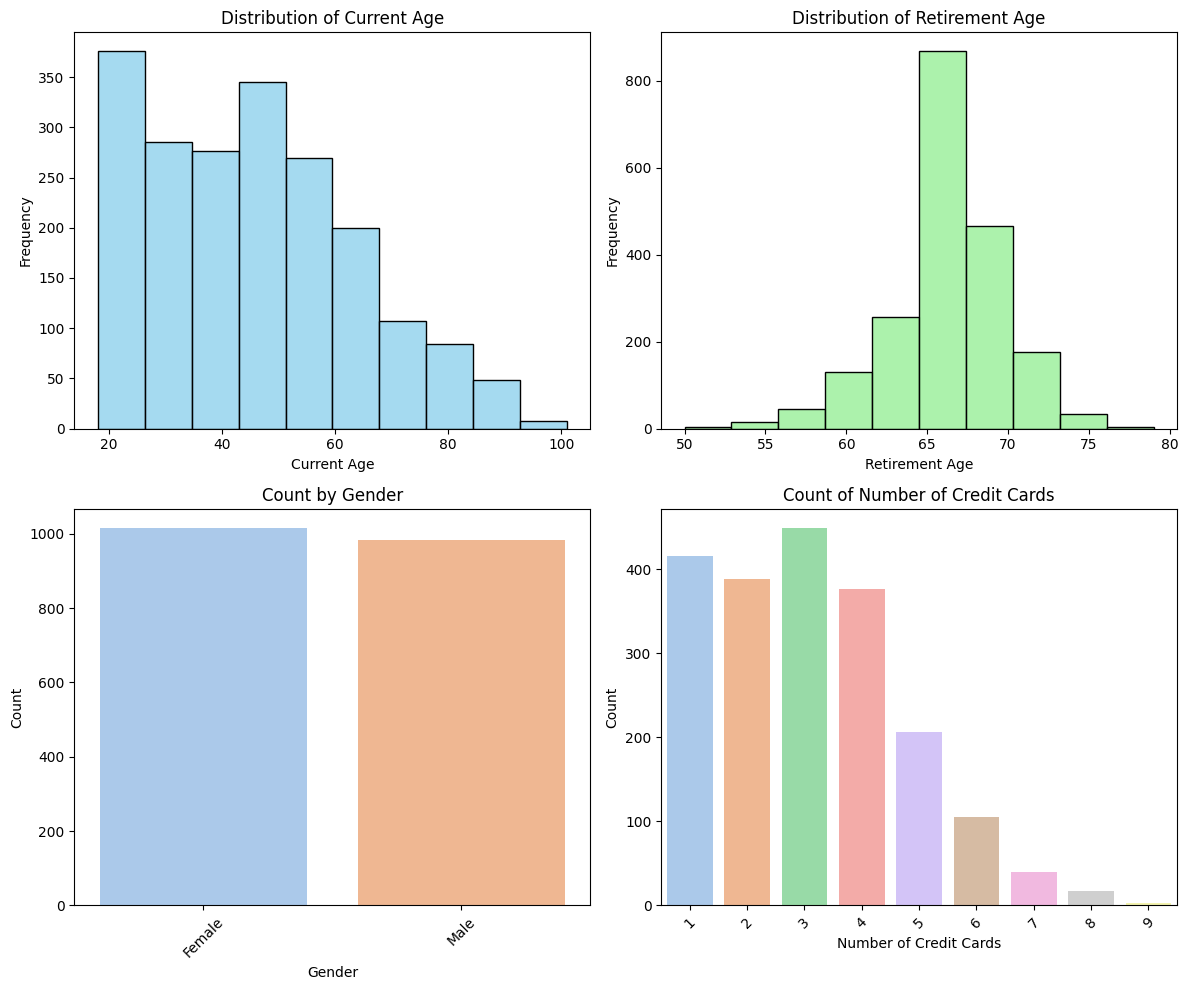

In [94]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# (A) Histogram for Current Age
sns.histplot(data=users, x="current_age", bins=10, ax=axes[0, 0], color="skyblue", edgecolor="black")
axes[0, 0].set_title("Distribution of Current Age")
axes[0, 0].set_xlabel("Current Age")
axes[0, 0].set_ylabel("Frequency")

# (B) Histogram for Retirement Age
sns.histplot(data=users, x="retirement_age", bins=10, ax=axes[0, 1], color="lightgreen", edgecolor="black")
axes[0, 1].set_title("Distribution of Retirement Age")
axes[0, 1].set_xlabel("Retirement Age")
axes[0, 1].set_ylabel("Frequency")

# (C) Count Plot for Gender
sns.countplot(data=users, x="gender", ax=axes[1, 0], palette="pastel")
axes[1, 0].set_title("Count by Gender")
axes[1, 0].set_xlabel("Gender")
axes[1, 0].set_ylabel("Count")
axes[1, 0].tick_params(axis="x", labelrotation=45)

# (D) Count Plot for Number of Credit Cards
sns.countplot(data=users, x="num_credit_cards", ax=axes[1, 1], palette="pastel")
axes[1, 1].set_title("Count of Number of Credit Cards")
axes[1, 1].set_xlabel("Number of Credit Cards")
axes[1, 1].set_ylabel("Count")
axes[1, 1].tick_params(axis="x", labelrotation=45)

plt.tight_layout()
plt.show()

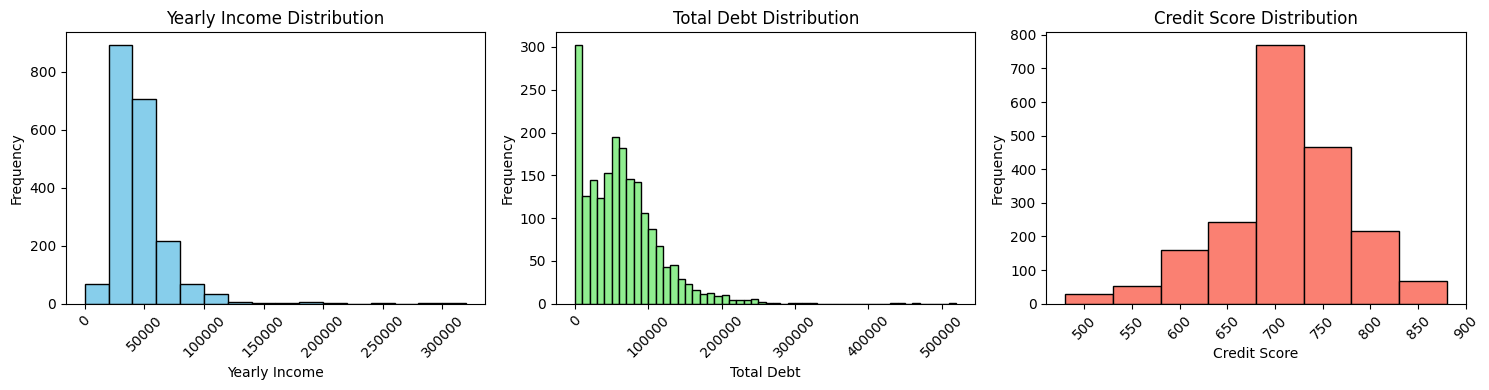

In [95]:
# Histogram for Yearly Income
min_income = users['yearly_income'].min()
max_income = users['yearly_income'].max()
bins_income = np.arange(min_income, max_income + 20000, 20000)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(users['yearly_income'], bins=bins_income, color='skyblue', edgecolor='black')
plt.title("Yearly Income Distribution")
plt.xlabel("Yearly Income")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

# Histogram for Total Debt
min_debt = users['total_debt'].min()
max_debt = users['total_debt'].max()
bins_debt = np.arange(min_debt, max_debt + 10000, 10000)

plt.subplot(1, 3, 2)
plt.hist(users['total_debt'], bins=bins_debt, color='lightgreen', edgecolor='black')
plt.title("Total Debt Distribution")
plt.xlabel("Total Debt")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

# Histogram for Credit Score
min_credit = users['credit_score'].min()
max_credit = users['credit_score'].max()
bins_credit = np.arange(min_credit, max_credit + 50, 50)

plt.subplot(1, 3, 3)
plt.hist(users['credit_score'], bins=bins_credit, color='salmon', edgecolor='black')
plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 1. Distribution of Current Age
- **Observation**: The histogram shows how ages are spread across the user base. A peak around 20-30 age ranges.  
- **Business Implication**:  
  - **Younger segment** might be interested in **education loans**, **starter credit cards**, or **first mortgage** products.  
  - **Middle-aged to older segment** could be prime candidates for **retirement planning**, **investment portfolios**, or **health insurance** products.

---

### 2. Distribution of Retirement Age
- **Observation**: Indicates the target age at which users plan (or have planned) to retire, mostly around 65 to 70 years old. Some users may have an earlier retirement horizon around 50.  
- **Business Implication**:  
  - Those with **soon-approaching retirement** can be offered **retirement investment accounts** or **pension bridging products**.  
  - Users with **later retirement ages** might be open to **longer-term investment vehicles** or **wealth-building** strategies.

---

### 3. Count by Gender
- **Observation**: Shows the similar proportion of male and female.  
- **Business Implication**:  
  - Demographic-based **targeted marketing** can address the unique financial needs or preferences correlated with gender segments.  
  - Helps ensure **inclusive product design** and messaging.

---

### 4. Count of Number of Credit Cards
- **Observation**: Most users have 1 to 4 credit cards.  
- **Business Implication**:  
  - **Low engagement** (1 card) → potential to **cross-sell** additional or premium cards.  
  - **High engagement** (3+ cards) → potential for **consolidation** offers or **elite rewards** programs.

---

### 5. Yearly Income Distribution
- **Observation**: Shows the spread of annual incomes. Skewed toward lower to mid-range with majority having $100000 income per year, with fewer high-income individuals.  
- **Business Implication**:  
  - **Higher income** → likely eligible for **premium credit lines**, **investment products**, or **mortgages**.  
  - **Mid/low income** → might be more interested in **credit-building** products, **lower interest** personal loans, or **basic insurance** coverage.

---

### 6. Total Debt Distribution
- **Observation**: Most customer have debt below $100000 where a peak is observed at the range of $0 to $10000  
- **Business Implication**:  
  - **High-debt users** may need **debt consolidation loans** or **refinancing** options.  
  - **Low-debt users** are prime for **additional credit offers** or **investment** recommendations (assuming good credit scores).

---

### 7. Credit Score Distribution
- **Observation**: Very close to normal distribution with a peak observed at score 700 to 750.  
- **Business Implication**:  
  - **High credit score** → eligibility for **premium rewards cards**, **lower interest** loans, or **preferred rates**.  
  - **Mid/low credit score** → target with **credit-building** products, secured cards, or **financial counseling** services.


## Drop unnecessary columns

In [96]:
users.drop(columns=['address','per_capita_income'], inplace=True)

users.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,34.15,-117.76,59696.0,127613.0,787,5
1,1746,53,68,1966,12,Female,40.76,-73.74,77254.0,191349.0,701,5
2,1718,81,67,1938,11,Female,34.02,-117.89,33483.0,196.0,698,5
3,708,63,63,1957,1,Female,40.71,-73.99,249925.0,202328.0,722,4
4,1164,43,70,1976,9,Male,37.76,-122.44,109687.0,183855.0,675,1


## Change gender to binary representation

In [97]:
users['gender'] = users['gender'].apply(lambda x: 1 if x == 'Male' else 0)
users.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,0,34.15,-117.76,59696.0,127613.0,787,5
1,1746,53,68,1966,12,0,40.76,-73.74,77254.0,191349.0,701,5
2,1718,81,67,1938,11,0,34.02,-117.89,33483.0,196.0,698,5
3,708,63,63,1957,1,0,40.71,-73.99,249925.0,202328.0,722,4
4,1164,43,70,1976,9,1,37.76,-122.44,109687.0,183855.0,675,1


## Merge users and cards data to be a single dataset

In [98]:
final_cards = pd.merge(users, cards_new, left_on='id', right_on='client_id', how='inner').sort_values('id').reset_index(drop=True)
final_cards.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards,client_id,Credit,Debit,Debit (Prepaid)
0,0,33,69,1986,3,1,43.59,-70.33,59613.0,36199.0,763,4,0,17600.0,88056.0,0.0
1,1,43,74,1976,4,0,30.44,-87.18,45360.0,14587.0,704,3,1,23700.0,18105.0,0.0
2,2,48,64,1971,8,1,40.84,-73.87,27447.0,80850.0,673,5,2,15200.0,35161.0,0.0
3,3,49,65,1970,12,1,33.89,-98.51,27943.0,18693.0,681,4,3,0.0,13515.0,207.0
4,4,54,72,1965,3,0,47.61,-122.30,76431.0,115362.0,716,5,4,19300.0,116902.0,0.0


## observe correlation matrix between features

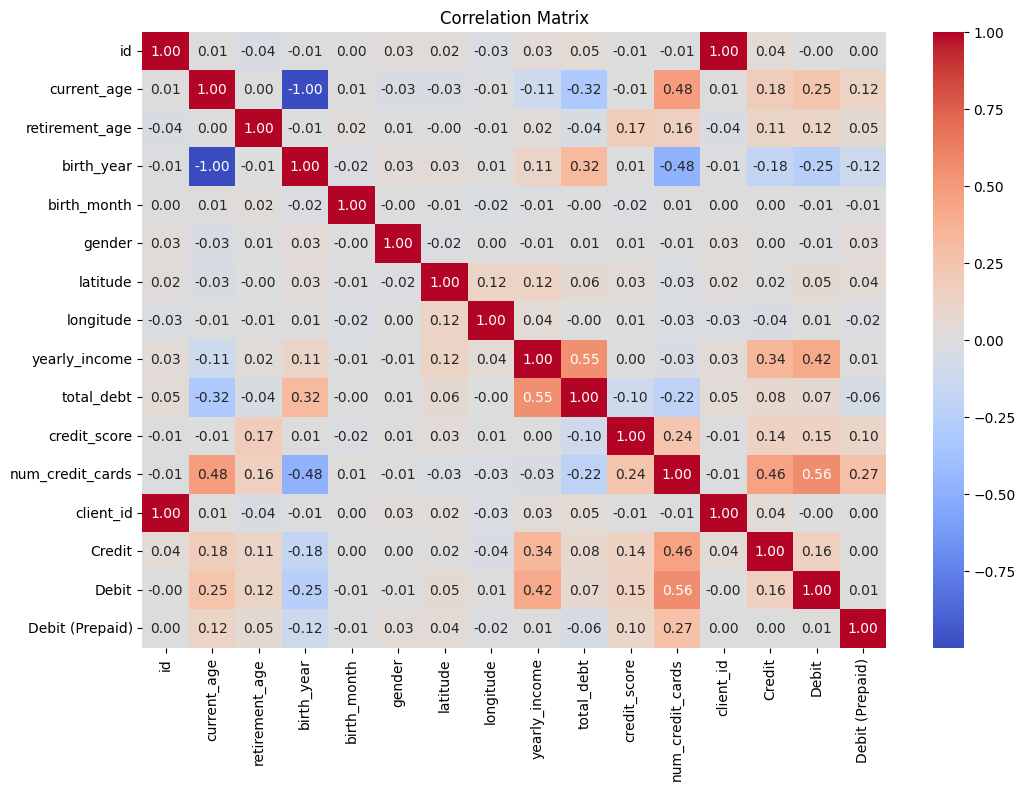

In [99]:
correlation_matrix = final_cards.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


`id` and `client_id` are duplications, hence drop of of them
`current_age` and `birth_year` are negatively correlated, hence drop one of them

In [100]:
final_cards.drop(columns=['client_id','birth_year'], inplace=True)

In [101]:
final_cards.head() 

,id,current_age,retirement_age,birth_month,gender,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards,Credit,Debit,Debit (Prepaid)
0,0,33,69,3,1,43.59,-70.33,59613.0,36199.0,763,4,17600.0,88056.0,0.0
1,1,43,74,4,0,30.44,-87.18,45360.0,14587.0,704,3,23700.0,18105.0,0.0
2,2,48,64,8,1,40.84,-73.87,27447.0,80850.0,673,5,15200.0,35161.0,0.0
3,3,49,65,12,1,33.89,-98.51,27943.0,18693.0,681,4,0.0,13515.0,207.0
4,4,54,72,3,0,47.61,-122.30,76431.0,115362.0,716,5,19300.0,116902.0,0.0


# EDA on transactions data

In [102]:
# print(transactions.shape) #(13305915, 12)
missing_values = transactions.isnull().sum()
missing_values

id                      0
date                    0
client_id               0
card_id                 0
amount                  0
use_chip                0
merchant_id             0
merchant_city           0
merchant_state     169554
zip                180663
mcc                     0
errors            1370654
dtype: int64

## select lastest year data
As purchasing pattern varies across years, people who used to buy luxuries 10 years ago could potentially change to a saving-oriented lifestyle for any reason. Hence we would only retrieve the most recent year data for training, which is also more align with the current situation.

In [103]:
transactions["date"] = pd.to_datetime(transactions["date"])
transactions['amount'] = transactions['amount'].replace({'\$': ''}, regex=True).astype(float)
end_date = transactions["date"].max()

# Set the start date to be 1 year before the end date
start_date = end_date - pd.DateOffset(years=1) + pd.Timedelta(days=1)

print(f"Start Date: {start_date.date()}")
print(f"End Date: {end_date.date()}")

tran_cards = transactions[(transactions["date"] >= start_date) & (transactions["date"] <= end_date)]

tran_cards.head(10)

Start Date: 2018-11-01
End Date: 2019-10-31


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
3891,22043152,2018-11-01 23:59:00,523,2713,89.32,Chip Transaction,60569,Holland,MI,49423.0,5300,NaN
3892,22043153,2018-11-02 00:00:00,554,2308,4.32,Chip Transaction,11468,League City,TX,77573.0,5970,NaN
3893,22043156,2018-11-02 00:04:00,848,5423,58.37,Chip Transaction,13051,Harwood,MD,20776.0,5813,NaN
3894,22043158,2018-11-02 00:11:00,496,5806,100.33,Online Transaction,73186,ONLINE,NaN,NaN,4814,NaN
3895,22043159,2018-11-02 00:12:00,641,2774,87.67,Swipe Transaction,26549,Columbus,OH,43228.0,5912,NaN
3896,22043160,2018-11-02 00:15:00,1585,2721,24.57,Chip Transaction,29547,Jacksonville,FL,32222.0,5812,NaN
3897,22043161,2018-11-02 00:19:00,605,5650,2.93,Chip Transaction,75781,Brooklyn,NY,11210.0,5411,NaN
3898,22043162,2018-11-02 00:21:00,430,5768,120.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
3899,22043164,2018-11-02 00:21:00,1684,2140,25.17,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN
3900,22043165,2018-11-02 00:23:00,86,4041,40.95,Online Transaction,39021,ONLINE,NaN,NaN,4784,NaN


/var/folders/tv/3hrqdjcx0qgbm22_5rmgrbd40000gn/T/ipykernel_56716/731518115.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=transactions, x="use_chip", palette="viridis")
/var/folders/tv/3hrqdjcx0qgbm22_5rmgrbd40000gn/T/ipykernel_56716/731518115.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


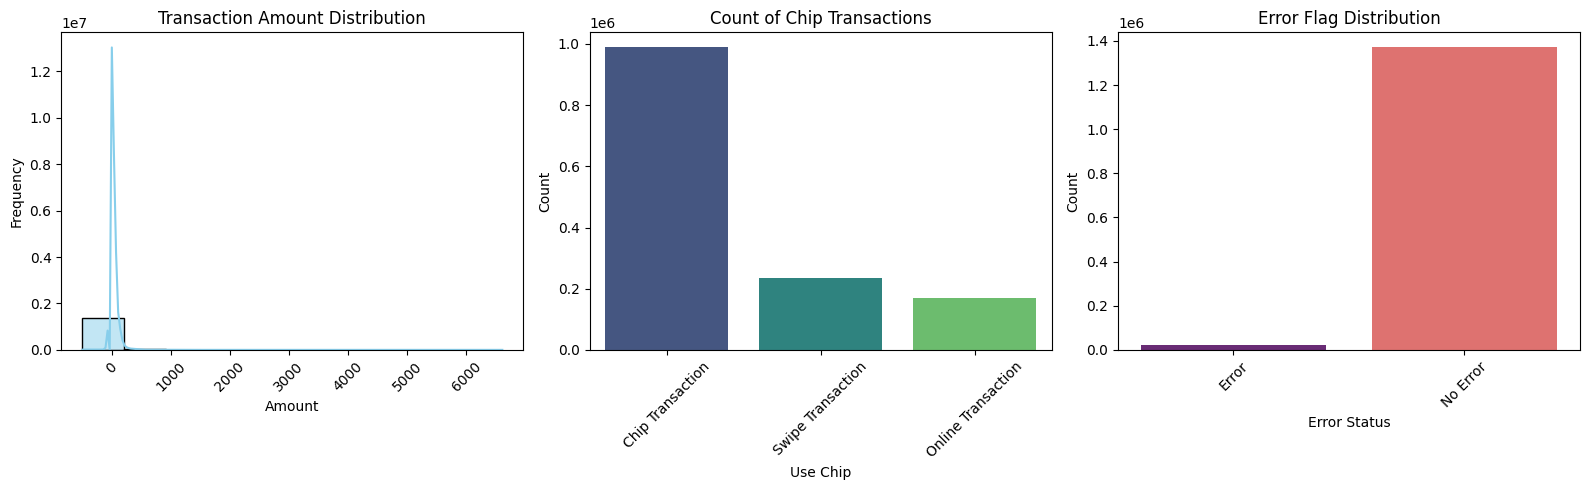

In [104]:
# Create a histogram for the transaction amounts.
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.histplot(transactions['amount'], bins=10, kde=True, color='skyblue', edgecolor='black')
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.xticks(rotation=45)

# Create a count plot for 'use_chip'
plt.subplot(1, 3, 2)
sns.countplot(data=transactions, x="use_chip", palette="viridis")
plt.title("Count of Chip Transactions")
plt.xlabel("Use Chip")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.countplot(
    x=transactions['errors'].apply(
        lambda x: "No Error" if pd.isna(x) or str(x).strip().lower() in ["nan", ""] else "Error"
    ),
    palette="magma"
)
plt.title("Error Flag Distribution")
plt.xlabel("Error Status")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 1. Transaction Amount Distribution

- **Observation:**  
  - The histogram reveals that the majority of transactions occur at lower amounts (e.g., under \$100) with a long tail representing occasional high-value transactions.
  
- **Business Implications:**  
  - **Frequent, Low-Value Transactions:**  
    - Indicates that many customers engage in everyday purchases.
    - Opportunity to promote **cashback programs** or **everyday rewards cards** that benefit small-ticket spending.
  - **High-Value Transactions:**  
    - Although less frequent, these may indicate occasions requiring higher credit limits.
    - Potential target for **premium card offers** or **financing products** (e.g., installment loans or purchase protection services).

---

### 2. Transaction Method (Use Chip)

- **Observation:**  
  - The count plot shows that the vast majority of transactions are tagged as "Chip Transaction," implying widespread use of chip-enabled cards.
  
- **Business Implications:**  
  - **Security & Adoption:**  
    - The dominance of chip transactions underscores customers' preference for secure, in-person payment methods.
    - Opportunity to emphasize security features in marketing campaigns.
  - **Upgrade Opportunities:**  
    - In cases where older, non-chip methods are still used (if present), these customers can be targeted for upgrades to more secure, modern payment cards.

---

### 3. Error Flag Distribution

- **Observation:**  
  - The histogram based on the `errors` column (transformed on the fly) shows that most transactions report "No Error," with only a small fraction indicating an error.
  
- **Business Implications:**  
  - **Reliability & Customer Trust:**  
    - A low error rate reflects a stable transaction system, which is crucial for customer trust.
  - **Risk Management:**  
    - Although errors are rare, identifying the few error cases is important as they may signal fraud, processing issues, or system anomalies.
    - These instances can trigger further investigation or enhanced fraud prevention measures.


## Remove errorneous transactions

In [105]:
tran_cards = tran_cards[tran_cards['errors'].isna()]
tran_cards.shape

(1366833, 12)

## Read-in mcc json file

In [106]:
# Load the JSON file
with open("/Users/manyuhaochi/Desktop/DSA3101/archive-2/mcc_codes.json", "r") as f:
    data = json.load(f)
data

{'5812': 'Eating Places and Restaurants',
 '5541': 'Service Stations',
 '7996': 'Amusement Parks, Carnivals, Circuses',
 '5411': 'Grocery Stores, Supermarkets',
 '4784': 'Tolls and Bridge Fees',
 '4900': 'Utilities - Electric, Gas, Water, Sanitary',
 '5942': 'Book Stores',
 '5814': 'Fast Food Restaurants',
 '4829': 'Money Transfer',
 '5311': 'Department Stores',
 '5211': 'Lumber and Building Materials',
 '5310': 'Discount Stores',
 '3780': 'Computer Network Services',
 '5499': 'Miscellaneous Food Stores',
 '4121': 'Taxicabs and Limousines',
 '5300': 'Wholesale Clubs',
 '5719': 'Miscellaneous Home Furnishing Stores',
 '7832': 'Motion Picture Theaters',
 '5813': 'Drinking Places (Alcoholic Beverages)',
 '4814': 'Telecommunication Services',
 '5661': 'Shoe Stores',
 '5977': 'Cosmetic Stores',
 '8099': 'Medical Services',
 '7538': 'Automotive Service Shops',
 '5912': 'Drug Stores and Pharmacies',
 '4111': 'Local and Suburban Commuter Transportation',
 '5815': 'Digital Goods - Media, Books,

### To analyse the purchase pattern, we first group similar merchant type into one big category, below are purely manual grouping to ensure all merchants are allocated to the most suitable category.

In [107]:
subgroup_mapping = {"Freight & Trucking": ["3730", "4214"],
    "Steel & Metal Products": ["3000", "3001", "3005", "3006", "3007", "3008", "3009",
                                 "3359", "3387", "3389", "3390", "3393", "3395", "3405", "5094"],
    "Retail Stores": ["5300", "5310", "5311", "5411", "5499","5193","3260"],
    "Digital Goods & Computers": ["5815", "5816", "5045"],
    "Utilities & Home Services": ["4900", "7210", "7349", "1711","5719","5712","3174","3144"],

    "Machinery & Tools": ["3058", "3066", "3075", "3504", "3509", "3596","5211","5261","3256"],
    
    "Rail & Bus Transport": ["3722", "3771", "3775", "4111", "4112", "4121", "4131", "4784", "3780"],
    
    "Telecommunications & Media": ["4814", "4829", "4899"],

    "Electronics & Appliances": ["3640","3684","5732","5251","5722"],
    "Automotive & Transportation Services": ["5533", "5541", "7531", "7538", "7542", "7549"],
    
    "Restaurants & Eating Places": ["5812", "5813", "5814"],
    
    "Clothing & Fashion": ["5621", "5651", "5655", "5661", "5977", "5932", "5947", "7230","3132"],
    
    "Movies & Theaters": ["7832", "7922", "5192", "5942"],
    "Sports & Recreational Activities": ["7801", "7802", "5941", "5970","7996","7995","5733"],
    
    "Medical & Healthcare Services": ["8011", "8021", "8041", "8043", "8049", "8062", "8099", "5912", "5921"],
    
    "Legal & Financial Services": ["8111", "8931", "7276", "7393","6300"],
    
    "Hotels & Accommodation": ["7011", "4411", "4511", "4722"],
    
    "Postal Services - Government Only": ["9402"],
}

# Create a reverse lookup: map each code to its category (subgroup)
code_to_category = {}
for category, codes in subgroup_mapping.items():
    for code in codes:
        code_to_category[code] = category

# Step 3: Prepare the CSV data
# The CSV will have three columns: Code, Product, Category
csv_rows = []
header = ["Code", "Product", "Category"]
csv_rows.append(header)

for code, product in data.items():
    # Use the category from our mapping; if a code isn't found, assign "Uncategorized"
    category = code_to_category.get(code, "Uncategorized")
    csv_rows.append([code, product, category])

# Step 4: Write the CSV file
# with open("output.csv", "w", newline="", encoding="utf-8") as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(csv_rows)

print("CSV file 'output.csv' has been created with assigned categories.")


CSV file 'output.csv' has been created with assigned categories.


## Create a dictionary to map mcc to its designated category

In [108]:
output = pd.read_csv("../data/processed/output.csv")

In [109]:
merged_trans = pd.merge(tran_cards, output, left_on='mcc', right_on='Code', how='left')
merged_trans.value_counts('client_id')
# Not all customer has transactions data

client_id
1098    4837
1963    4370
1776    4258
909     4222
114     3959
        ... 
1002     336
19       315
1749     292
1016     223
1649     210
Name: count, Length: 1206, dtype: int64

## Group the data to see each customer's spending in every category where applicable

In [110]:
category_spend = merged_trans.groupby(['client_id', 'Category'])['amount'].sum().reset_index()
category_spend.head()

,client_id,Category,amount
0,0,Automotive & Transportation Services,5605.50
1,0,Clothing & Fashion,1915.53
2,0,Digital Goods & Computers,664.27
3,0,Electronics & Appliances,568.06
4,0,Freight & Trucking,284.24


## Pivot the table wider for label construction later on.

In [111]:
spending = category_spend.pivot(index='client_id', columns='Category', values='amount').fillna(0).reset_index()
spending.head()

Category,client_id,Automotive & Transportation Services,Clothing & Fashion,Digital Goods & Computers,Electronics & Appliances,Freight & Trucking,Hotels & Accommodation,Legal & Financial Services,Machinery & Tools,Medical & Healthcare Services,Movies & Theaters,Postal Services - Government Only,Rail & Bus Transport,Restaurants & Eating Places,Retail Stores,Sports & Recreational Activities,Steel & Metal Products,Telecommunications & Media,Utilities & Home Services
0,0,5605.50,1915.53,664.27,568.06,284.24,1844.99,46.14,3107.03,3140.13,808.03,296.44,1415.70,12778.17,13124.77,693.76,1237.11,6265.45,6035.36
1,1,3111.27,1921.15,0.00,513.08,0.00,0.00,176.38,1127.58,2280.52,507.43,0.00,8470.32,2655.97,3373.12,0.00,299.26,6291.66,3002.74
2,2,2622.32,408.42,64.42,1.45,1505.29,0.00,2749.38,1115.31,2655.42,873.73,1618.69,660.48,0.00,8383.81,816.51,0.00,2755.43,2372.51
3,3,3713.10,303.74,472.75,0.00,0.00,222.86,1453.58,367.59,4924.26,72.39,0.00,1048.72,319.42,12492.86,6.76,980.88,662.82,1860.70
4,4,4640.46,1884.95,49.01,727.39,23.93,0.00,3710.66,821.71,4847.20,2037.63,22.68,281.70,19519.36,7662.54,1075.61,245.37,8251.47,3114.92


## Merge all three datasets together

In [112]:
final = pd.merge(final_cards, spending, left_on='id', right_on='client_id', how='left')

## Drop `id` and `clinet_id` columns

In [113]:
final.drop(columns=['client_id','id'], inplace=True)
final.head()

,current_age,retirement_age,birth_month,gender,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards,...,Medical & Healthcare Services,Movies & Theaters,Postal Services - Government Only,Rail & Bus Transport,Restaurants & Eating Places,Retail Stores,Sports & Recreational Activities,Steel & Metal Products,Telecommunications & Media,Utilities & Home Services
0,33,69,3,1,43.59,-70.33,59613.0,36199.0,763,4,...,3140.13,808.03,296.44,1415.70,12778.17,13124.77,693.76,1237.11,6265.45,6035.36
1,43,74,4,0,30.44,-87.18,45360.0,14587.0,704,3,...,2280.52,507.43,0.00,8470.32,2655.97,3373.12,0.00,299.26,6291.66,3002.74
2,48,64,8,1,40.84,-73.87,27447.0,80850.0,673,5,...,2655.42,873.73,1618.69,660.48,0.00,8383.81,816.51,0.00,2755.43,2372.51
3,49,65,12,1,33.89,-98.51,27943.0,18693.0,681,4,...,4924.26,72.39,0.00,1048.72,319.42,12492.86,6.76,980.88,662.82,1860.70
4,54,72,3,0,47.61,-122.30,76431.0,115362.0,716,5,...,4847.20,2037.63,22.68,281.70,19519.36,7662.54,1075.61,245.37,8251.47,3114.92


## Save data to processed data

In [120]:
#final.to_csv('../data/processed/final_data.csv', index=False)

In our analysis, we observed that not all customers have complete transaction data, particularly for spending in various categories, which could limit our insights and model performance. To address this, we use the KNNImputer to estimate missing values, ensuring maximum utilization of available data. Specifically, we create the function `evaluate_knn_imputer_scaled_transform_original` to find the best k to use for this dataset. It first creates a copy of the dataset and then, for each target spending column, randomly masks a fraction of the non-missing values. A pipeline is applied that standardizes the data and then imputes the missing values using KNNImputer with a specified number of neighbors. The imputed values are compared against the original masked values (after scaling) using mean squared error (MSE), and the average MSE across all target columns is computed as a measure of imputation performance. This approach not only recovers missing data based on the similarity among customers but also provides a quantitative metric to assess the quality of the imputation, which is essential for building robust recommendation models.

In [121]:
def evaluate_knn_imputer_scaled_transform_original(n_neighbors, data, target_cols, mask_frac=0.1, random_state=42):
    mse_list = []
    # Work on a copy so that modifications for one column do not affect the others.
    data_copy = data.copy()
    np.random.seed(random_state)
    
    for col in target_cols:
        non_missing_idx = data_copy[data_copy[col].notnull()].index
        if len(non_missing_idx) == 0:
            continue
        
        # Randomly mask a fraction of non-missing values
        mask_idx = np.random.choice(non_missing_idx, 
                                     size=int(mask_frac * len(non_missing_idx)), 
                                     replace=False)
        original_values = data_copy.loc[mask_idx, col].copy()
        data_copy.loc[mask_idx, col] = np.nan
        
        # Build a pipeline: Standardize then impute
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('imputer', KNNImputer(n_neighbors=n_neighbors))
        ])
        
        imputed_array = pipeline.fit_transform(data_copy)
        imputed_cards = pd.DataFrame(imputed_array, columns=data_copy.columns, index=data_copy.index)
        
        # Retrieve the fitted scaler to manually scale original values
        fitted_scaler = pipeline.named_steps['scaler']
        col_index = list(data_copy.columns).index(col)
        
        # Scale the original (masked) values using the fitted scaler parameters
        original_values_scaled = (original_values - fitted_scaler.mean_[col_index]) / fitted_scaler.scale_[col_index]
        imputed_values_scaled = imputed_cards.loc[mask_idx, col]
        
        mse = mean_squared_error(original_values_scaled, imputed_values_scaled)
        mse_list.append(mse)
        
        # Restore original values so the next iteration works on unmodified data_copy
        data_copy.loc[mask_idx, col] = original_values
        
    return np.mean(mse_list)

## Data Preparation and Column Selection: 

First, we define two sets of columns: one for target spending categories and another for additional features that will help in the imputation process. The target columns include various spending categories (such as 'Automotive & Transportation Services', 'Clothing & Fashion', etc.), while the feature columns capture customer demographics and financial metrics (like 'current_age', 'yearly_income', 'credit_score', etc.). These lists are combined into a single list (`cols_for_impute`), and a working DataFrame (`cards_impute`) is created from the main DataFrame (`final`) that contains only these selected columns. This ensures that the subsequent imputation process uses both the spending data and relevant contextual information.

In [122]:
target_cols = ['Automotive & Transportation Services', 'Clothing & Fashion',
       'Digital Goods & Computers', 'Electronics & Appliances',
       'Freight & Trucking', 'Hotels & Accommodation',
       'Legal & Financial Services', 'Machinery & Tools',
       'Medical & Healthcare Services', 'Movies & Theaters',
       'Postal Services - Government Only', 'Rail & Bus Transport',
       'Restaurants & Eating Places', 'Retail Stores',
       'Sports & Recreational Activities', 'Steel & Metal Products',
       'Telecommunications & Media', 'Utilities & Home Services']

# List of feature columns used for imputation
feature_cols = ['current_age', 'retirement_age', 'birth_month', 'gender',
       'latitude', 'longitude', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'Credit', 'Debit', 'Debit (Prepaid)']

# Create a working DataFrame with both feature and target columns.
# (Assuming you have a DataFrame called 'final' already loaded.)
cols_for_impute = feature_cols + target_cols
cards_impute = final[cols_for_impute].copy()



## Evaluating the KNN Imputer Performance:  

The code then evaluates the performance of the KNN imputer over a range of neighbor values (from 2 to 10) using a function called `evaluate_knn_imputer_scaled_transform_original`. This function works by artificially masking a fraction of non-missing values in each target spending column and then applying a pipeline that first scales the data using `StandardScaler` and then imputes the missing values with `KNNImputer`. For each neighbor value (n_neighbors), the function calculates the mean squared error (MSE) between the imputed values and the original (scaled) values that were masked. The resulting MSE for each n_neighbors value is stored in a dictionary (`results_scaled`), and an elbow plot is generated to visualize how the MSE changes with different numbers of neighbors. This plot helps in identifying the optimal value of n_neighbors—where the MSE is minimized without overfitting. In this case, the best n_neighbors is determined to be 5.

n_neighbors = 2, MSE (standardized) = 1.1091732862419705
n_neighbors = 3, MSE (standardized) = 0.9758764986464524
n_neighbors = 4, MSE (standardized) = 0.933294640051493
n_neighbors = 5, MSE (standardized) = 0.9180345388022791
n_neighbors = 6, MSE (standardized) = 0.9055771121625248
n_neighbors = 7, MSE (standardized) = 0.8985273950711282
n_neighbors = 8, MSE (standardized) = 0.9038361977113308
n_neighbors = 9, MSE (standardized) = 0.8935094147301142
n_neighbors = 10, MSE (standardized) = 0.8963641466842264


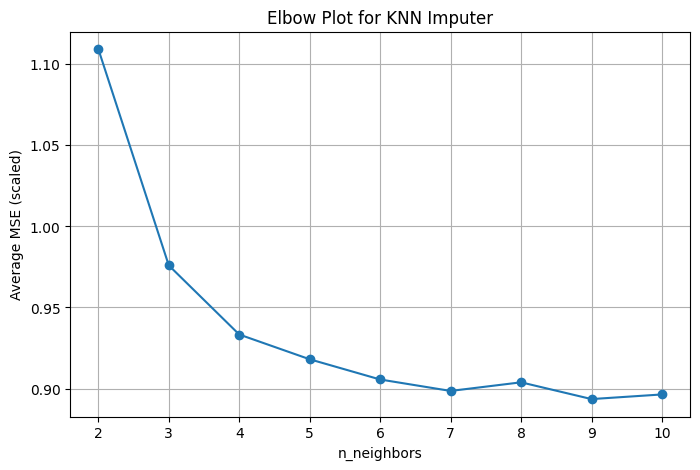

In [123]:
# Evaluate a range of n_neighbors (e.g., 2 to 10) and record the MSE for each.
results_scaled = {}
ks = list(range(2, 11))
for k in ks:
    mse = evaluate_knn_imputer_scaled_transform_original(k, cards_impute, target_cols, mask_frac=0.1, random_state=42)
    results_scaled[k] = mse
    print(f"n_neighbors = {k}, MSE (standardized) = {mse}")

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(ks, [results_scaled[k] for k in ks], marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('Average MSE (scaled)')
plt.title('Elbow Plot for KNN Imputer')
plt.grid(True)
plt.show()



## Building the Final Pipeline and Imputing Missing Values:  

After selecting the best neighbor count, the code builds a final pipeline consisting of a `StandardScaler` followed by a `KNNImputer` (with n_neighbors set to the optimal value of 5). This pipeline is applied to the working DataFrame (`cards_impute`), resulting in an imputed and scaled NumPy array. This array is then converted back into a DataFrame (`cards_imputed_scaled`) with the original column names and indices, so you can inspect the imputed and standardized data.

In [124]:
# Select the best n_neighbors (with the lowest MSE)
best_n = 5
print("Best n_neighbors (standardized):", best_n)

# Build final pipeline and impute missing values using the best n_neighbors.
pipeline_final = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=best_n))
])
imputed_array = pipeline_final.fit_transform(cards_impute)
# Save the imputed & scaled DataFrame.
cards_imputed_scaled = pd.DataFrame(imputed_array, columns=cards_impute.columns, index=cards_impute.index)
print("Head of imputed and scaled data:")
print(cards_imputed_scaled.head())

Best n_neighbors (standardized): 5
Head of imputed and scaled data:
   current_age  retirement_age  birth_month    gender  latitude  longitude  \
0    -0.673104        0.761447    -0.964806  1.016130  1.212736   1.303795   
1    -0.129906        2.139632    -0.684258 -0.984126 -1.359117   0.268733   
2     0.141693       -0.616738     0.437936  1.016130  0.674896   1.086340   
3     0.196013       -0.341101     1.560130  1.016130 -0.684372  -0.427246   
4     0.467612        1.588358    -0.964806 -0.984126  1.998960  -1.888618   

   yearly_income  total_debt  credit_score  num_credit_cards  ...  \
0       0.604568   -0.526607      0.792581          0.566290  ...   
1      -0.015482   -0.940302     -0.085328         -0.044595  ...   
2      -0.794753    0.328098     -0.546603          1.177175  ...   
3      -0.773175   -0.861706     -0.427564          0.566290  ...   
4       1.336203    0.988724      0.093229          1.177175  ...   

   Medical & Healthcare Services  Movies & Theat

## Inverse Transformation to Original Scale:  

Since the imputation was performed on scaled data, it is often desirable to convert the data back to its original scale for further analysis or business interpretation. The code retrieves the fitted scaler from the pipeline and applies its `inverse_transform` method to the imputed scaled DataFrame. This produces a new DataFrame (`cards_imputed_original`) where the imputed values are restored to their original scale. Finally, the code prints the head of both the imputed scaled and original-scale DataFrames so you can compare and verify the results.

In [119]:
scaler = pipeline_final.named_steps['scaler']
# Inverse-transform the imputed scaled data.
df_imputed_original_array = scaler.inverse_transform(cards_imputed_scaled)
df_imputed_original = pd.DataFrame(df_imputed_original_array, columns=cards_impute.columns, index=cards_impute.index)
print("Head of imputed data in original scale:")
df_imputed_original.head(10)

Head of imputed data in original scale:


,current_age,retirement_age,birth_month,gender,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards,...,Medical & Healthcare Services,Movies & Theaters,Postal Services - Government Only,Rail & Bus Transport,Restaurants & Eating Places,Retail Stores,Sports & Recreational Activities,Steel & Metal Products,Telecommunications & Media,Utilities & Home Services
0,33.0,69.0,3.0,1.0,43.59,-70.33,59613.0,36199.0,763.0,4.0,...,3140.130,808.030,2.964400e+02,1415.700,12778.170,13124.770,693.760,1237.110,6265.450,6035.360
1,43.0,74.0,4.0,0.0,30.44,-87.18,45360.0,14587.0,704.0,3.0,...,2280.520,507.430,1.421085e-14,8470.320,2655.970,3373.120,0.000,299.260,6291.660,3002.740
2,48.0,64.0,8.0,1.0,40.84,-73.87,27447.0,80850.0,673.0,5.0,...,2655.420,873.730,1.618690e+03,660.480,0.000,8383.810,816.510,0.000,2755.430,2372.510
3,49.0,65.0,12.0,1.0,33.89,-98.51,27943.0,18693.0,681.0,4.0,...,4924.260,72.390,1.421085e-14,1048.720,319.420,12492.860,6.760,980.880,662.820,1860.700
4,54.0,72.0,3.0,0.0,47.61,-122.30,76431.0,115362.0,716.0,5.0,...,4847.200,2037.630,2.268000e+01,281.700,19519.360,7662.540,1075.610,245.370,8251.470,3114.920
5,65.0,65.0,2.0,1.0,42.95,-77.13,20614.0,14042.0,711.0,2.0,...,4236.320,625.150,1.421085e-14,571.570,905.850,2751.480,87.940,1.910,5767.950,6020.500
6,19.0,63.0,6.0,0.0,32.88,-117.13,55854.0,111042.0,782.0,1.0,...,4041.622,1427.874,4.908000e+00,2314.898,3094.864,10956.288,5892.872,524.828,7590.434,2924.472
7,74.0,61.0,5.0,1.0,39.30,-76.61,32682.0,21379.0,650.0,3.0,...,2541.028,380.332,7.786000e+00,5908.786,1251.382,5691.586,326.468,320.888,5873.650,3594.442
8,21.0,69.0,8.0,1.0,27.95,-82.48,38497.0,33413.0,699.0,2.0,...,3768.570,330.178,4.291120e+02,1790.406,1898.992,8756.822,131.534,568.586,5729.234,2761.140
9,29.0,60.0,12.0,1.0,32.63,-117.05,40988.0,89801.0,540.0,3.0,...,4222.776,918.794,8.651800e+01,3850.696,1815.572,10731.920,576.952,593.246,9224.158,3073.352


## Save imputed data to processed data

In [ ]:
#df_imputed_original.to_csv('../data/processed/imputed_data.csv', index=False)